In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
import os
from torchvision.transforms import v2
import torch
import shutil
from PIL import Image
from ultralytics import YOLO
import cv2

# Local dep
project_dir = '/data/konrad/workspace'
sys.path.insert(0, project_dir)

from helpers.datasets import CalfCenterFaceDataset
from helpers.helpers import get_indices, uniform_sample_with_values, load_face_data

In [6]:
ROOT_DIR = "/data/konrad/workspace"
DATA_FILE = ROOT_DIR + '/datasets/CompleteDatasetNormalFace/Face_annotations.csv'
IMAGE_DIR = ROOT_DIR + "/datasets/CompleteDatasetNormalFace"

face_df, labels, label2id, id2label = load_face_data(DATA_FILE, IMAGE_DIR)
face_df["img_dir"] = IMAGE_DIR
face_df["type"] = 0

# DATA_FILE = '/data/konrad/datasets/CompleteDatasetNormalProfilDroit/Profil_droit_annotations.csv'
# IMAGE_DIR = "/data/konrad/datasets/CompleteDatasetNormalProfilDroit"

# rigth_df, _, _, _ = load_face_data(DATA_FILE, IMAGE_DIR, extract_name=False)
# rigth_df["img_dir"] = IMAGE_DIR
# rigth_df["type"] = 1


# DATA_FILE = '/data/konrad/datasets/CompleteDatasetNormalProfilGauche/Profil_gauche_annotations.csv'
# IMAGE_DIR = "/data/konrad/datasets/CompleteDatasetNormalProfilGauche"

# left_df, _, _, _ = load_face_data(DATA_FILE, IMAGE_DIR, extract_name=False)
# left_df["img_dir"] = IMAGE_DIR
# left_df["type"] = 2

mix_df = pd.concat([face_df], ignore_index=True)
# mix_df = pd.concat([face_df, rigth_df, left_df], ignore_index=True)
# mix_df['type'] = 0 Only for any detector

In [9]:
def plot_bbox_gallery(image_df, n_cols=5):
    n_images = image_df.shape[0]
    n_rows = n_images // n_cols + int(n_images % n_cols > 0)
    
    plt.figure(figsize=(20, n_rows * 4))
    for i, row in image_df.iterrows():
        img = Image.open(row["path"])
        # plt.subplot(n_rows, n_cols, i + 1)
        ax = plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        # ax = plt.gca()
        score = row["conf"]
        box_x = row["box_x"]
        box_y = row["box_y"]
        box_width = row["box_width"]
        box_height = row["box_height"]
        box_x = box_x - (box_width / 2)
        box_y = box_y - (box_height / 2)
        rect = plt.Rectangle((box_x, box_y), box_width, box_height, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(box_x, box_y - 10, f' {score:.2f}', color='red', fontsize=12, backgroundcolor='white')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [5]:
result.shape, label2id

((519, 10), {'Diarrhea': 0, 'Pneumonia': 1, 'Healthy': 2})

In [7]:
# valid_set_size = 18
filter_values = {
    # 'calf': ['6842', '6445', '6860'],  # Specify the values you want to include
    'calf': ['6842', '6436', '6864'],  # Specify the values you want to include
}
# groupby_cols = ['calf']
# valid_df, _ = uniform_sample_with_values(df, valid_set_size, groupby_cols, filter_values=filter_values)

valid_df = mix_df[mix_df['calf'].isin(filter_values['calf'])]
train_df = mix_df[~ mix_df['calf'].isin(filter_values['calf'])]

In [8]:
def df_to_yolo(df, root_dir, img_src_dir = None):
    
    img_path = root_dir + "/" + "images"
    if not os.path.exists(img_path):
        os.makedirs(img_path)

    lbl_path = root_dir + "/" + "labels"
    if not os.path.exists(lbl_path):
        os.makedirs(lbl_path)

    for index, row in df.iterrows():
        # Extract the image name
        image_name = row['path']

        img_src_dir = row['img_dir']
        shutil.copy(os.path.join(img_src_dir, image_name), os.path.join(img_path, image_name))
        filename = os.path.splitext(image_name)[0]

        # Open the image file
        with Image.open(os.path.join(img_src_dir, image_name)) as img:
            # Get the width and height
            imgWidth, imgHeight = img.size

        class_idx = row['type']
        # class_idx = 0

        xmin = row['xmin']
        ymin = row['ymin']
        xmax = row['xmax']
        ymax = row['ymax']

        center_x = (xmin + xmax) / 2.0
        center_y = (ymin + ymax) / 2.0

        width = xmax - xmin
        height = ymax - ymin

        
        # image = cv2.imread(os.path.join(img_src_dir, image_name))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        # plt.figure(figsize=(10, 10))
        # plt.imshow(image)
        # ax = plt.gca()
        
        # rect = plt.Rectangle((xmin, ymin), width, height, edgecolor='r', facecolor='none')
        # ax.add_patch(rect)
        # plt.axis('off')
        # plt.show()

        # print(center_x == (xmin + (width / 2)), center_x, xmin + (width / 2))
        # break
        
        norm_center_x = center_x / imgWidth
        norm_center_y = center_y / imgHeight
        
        norm_width = width / imgWidth
        norm_height = height / imgHeight
        
        box_annotation = ' '.join([str(class_idx), str(norm_center_x), str(norm_center_y), str(norm_width), str(norm_height)])+'\n'

        label_filename = lbl_path + '/' + filename + ".txt"
        anno_f = open(label_filename, 'w')
        anno_f.writelines(box_annotation)
        anno_f.close()

    print("Done !")

In [10]:
IMAGE_DIR = ROOT_DIR + "/datasets/calfs_face"
df_to_yolo(train_df, IMAGE_DIR + '/train', IMAGE_DIR)
df_to_yolo(valid_df, IMAGE_DIR + '/test', IMAGE_DIR)

Done !
Done !


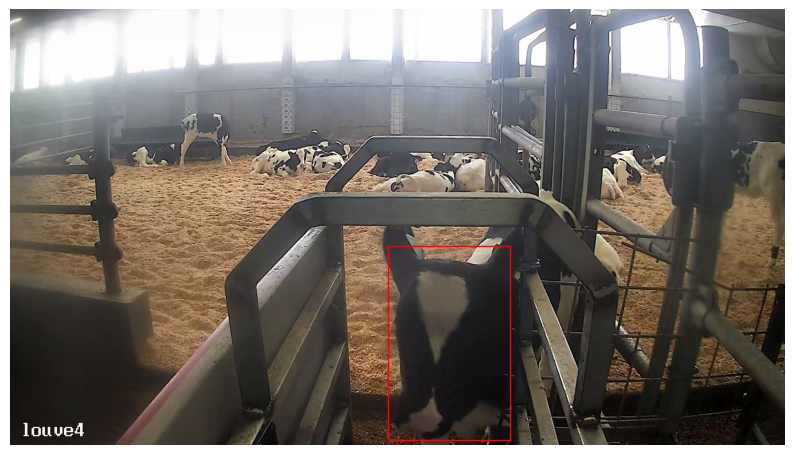

In [58]:
img_path = ROOT_DIR + "/datasets/CompleteDatasetNormalFace/train/images/_6388_ch10_from_28022022130430__to__28022022131044.mp4#t=143.466667.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_height, image_width, _ = image.shape
box = [0.5662488063712934, 0.7654481498495793, 0.15660561659986735, 0.4459691775601684,]
center_x, center_y, width, height = box

x1 = center_x * image_width - ((width * image_width) / 2)
y1 = center_y * image_height - ((height * image_height) / 2)
w = width * image_width
h = height * image_height

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
ax = plt.gca()

rect = plt.Rectangle((x1, y1), w, h, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.show()

In [22]:
# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Train the model
# results = model.train(data="yolo.yml", epochs=10)

results = model.train(data="yolo-face.yml", epochs=10, project=ROOT_DIR + "/training_log", name="yolo_face", cfg="config.yml")

model.export()

New https://pypi.org/project/ultralytics/8.2.63 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.58 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24115MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo-face.yml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/data/konrad/workspace/training_log, name=yolo_face, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=F

train: Scanning /data/konrad/workspace/datasets/calfs_face/train/labels.cache... 178 images, 0 backgrounds, 0 corrupt: 100%|██████████| 178/178 [00:00<?, ?it/s]
val: Scanning /data/konrad/workspace/datasets/calfs_face/test/labels.cache... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<?, ?it/s]


Plotting labels to /data/konrad/workspace/training_log/yolo_face/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /data/konrad/workspace/training_log/yolo_face
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.09G      2.376       4.38      2.308          2        640: 100%|██████████| 12/12 [00:01<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.05it/s]

                   all          9          9    0.00222      0.667     0.0329    0.00972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.03G      1.695      3.019      1.707          2        640: 100%|██████████| 12/12 [00:00<00:00, 19.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.71it/s]

                   all          9          9    0.00259      0.778     0.0505     0.0111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.02G      1.501      2.593       1.54          2        640: 100%|██████████| 12/12 [00:00<00:00, 20.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.51it/s]

                   all          9          9    0.00296      0.889      0.291     0.0533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.02G      1.379      2.263       1.45          2        640: 100%|██████████| 12/12 [00:00<00:00, 20.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 34.04it/s]

                   all          9          9    0.00296      0.889      0.192     0.0563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.02G       1.34      2.169      1.345          2        640: 100%|██████████| 12/12 [00:00<00:00, 20.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.88it/s]

                   all          9          9       0.37      0.444      0.467      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.02G      1.331      1.902      1.299          2        640: 100%|██████████| 12/12 [00:00<00:00, 21.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 35.00it/s]

                   all          9          9      0.977      0.444      0.601      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.02G      1.305      1.841      1.233          2        640: 100%|██████████| 12/12 [00:00<00:00, 21.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 36.23it/s]

                   all          9          9      0.613      0.556      0.644      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.02G       1.32      1.794       1.27          2        640: 100%|██████████| 12/12 [00:00<00:00, 21.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.67it/s]

                   all          9          9      0.618      0.556      0.495      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.02G      1.241      1.636      1.216          2        640: 100%|██████████| 12/12 [00:00<00:00, 22.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.90it/s]

                   all          9          9      0.652      0.444      0.491      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.02G      1.236        1.5      1.217          2        640: 100%|██████████| 12/12 [00:00<00:00, 22.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 37.13it/s]

                   all          9          9      0.752      0.444      0.519      0.201



10 epochs completed in 0.004 hours.
Optimizer stripped from /data/konrad/workspace/training_log/yolo_face/weights/last.pt, 6.2MB
Optimizer stripped from /data/konrad/workspace/training_log/yolo_face/weights/best.pt, 6.2MB

Validating /data/konrad/workspace/training_log/yolo_face/weights/best.pt...
Ultralytics YOLOv8.2.58 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24115MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 44.44it/s]


                   all          9          9      0.613      0.556      0.644      0.234
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /data/konrad/workspace/training_log/yolo_face
Ultralytics YOLOv8.2.58 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (AMD Ryzen Threadripper PRO 5975WX 32-Cores)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/data/konrad/workspace/training_log/yolo_face/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.9 MB)

TorchScript: starting export with torch 2.3.1+cu121...
TorchScript: export success ✅ 0.7s, saved as '/data/konrad/workspace/training_log/yolo_face/weights/best.torchscript' (11.9 MB)

Export complete (2.0s)
Results saved to /data/konrad/workspace/training_log/yolo_face/weights
Predict:         yolo predict task=detect model=/data/konrad/workspace/training_log/yolo_face/weights/best.torchscript imgsz=640 

'/data/konrad/workspace/training_log/yolo_face/weights/best.torchscript'

In [3]:
finetuned_model = YOLO("./runs/detect/train2/weights/best.pt")  # load a pretrained model (recommended for training)


image 1/1 /data/konrad/video_classification/temp_images/Pneumonie/image_1_0_6370_10_2022-02-23 06:40:53_Pneumonie.png: 384x640 (no detections), 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


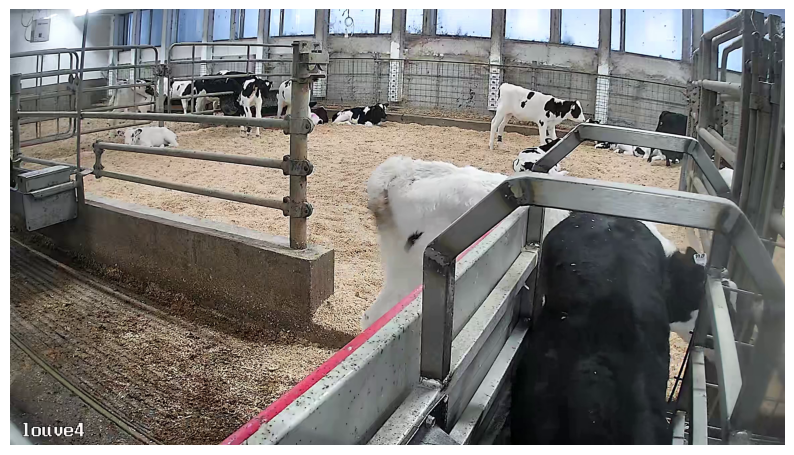

In [11]:
img_path = ROOT_DIR + "/video_classification/temp_images/Pneumonie/image_1_0_6370_10_2022-02-23 06:40:53_Pneumonie.png"

results = finetuned_model.predict(img_path, save=False, imgsz=640, conf=0.5, max_det=1, show=False)

result = results[0]
boxes = result.boxes  # Assuming the results contain 'boxes'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
ax = plt.gca()

# Plot the bounding boxes and labels
# for box, label, score in zip(boxes, labels, scores):
for box in zip(boxes):
    # print(box)
    x1, y1, width, height = box[0].xywh[0].cpu()
    score = box[0].conf[0].cpu()
    # width, height = x2 - x1, y2 - y1
    # rect = plt.Rectangle((x1 - (width / 2), y1 - (height / 2)), width, height, edgecolor='r', facecolor='none')
    rect = plt.Rectangle((x1, y1), width, height, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x1, y1 - 10, f' {score:.2f}', color='red', fontsize=12, backgroundcolor='white')

plt.axis('off')
plt.show()


image 1/1 /data/konrad/video_classification/temp_images/Diarrhé/image_6_1_6778_2_2022-02-26 18:06:52_Diarrhé.png: 384x640 1 Face, 71.1ms
Speed: 4.3ms preprocess, 71.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
False


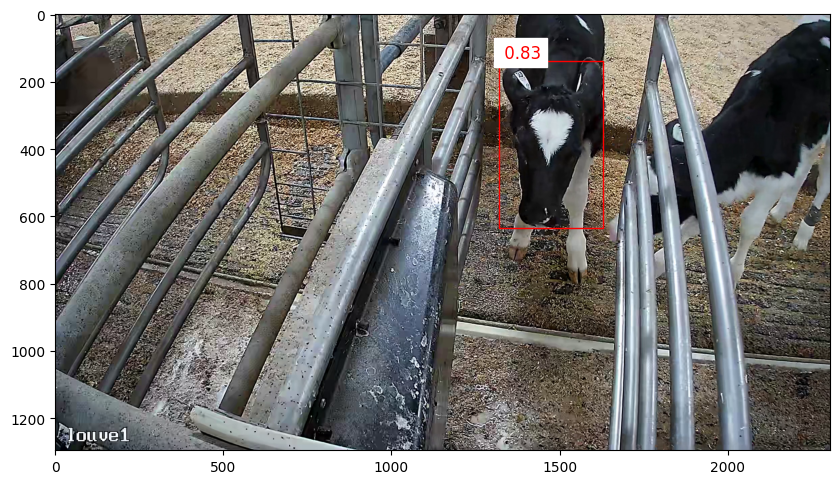

In [5]:
# img_path = ROOT_DIR + "/video_classification/temp_images/Pneumonie/image_7_11_6768_2_2022-02-22 21:04:36_Pneumonie.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Pneumonie/image_0_4_6375_10_2022-03-01 19:46:38_Pneumonie.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Healthy/image_1_15_6728_10_2022-02-19 20:56:23_Healthy.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Diarrhé/image_9_15_6393_10_2022-02-16 09:01:56_Diarrhé.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Diarrhé/image_6_7_6799_1_2022-02-26 18:32:00_Diarrhé.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Diarrhé/image_6_1_6778_2_2022-02-26 18:06:52_Diarrhé.png"
img_path = ROOT_DIR + "/video_classification/temp_images/Diarrhé/image_6_1_6778_2_2022-02-26 18:06:52_Diarrhé.png"

# results = finetuned_model.predict(img_path, save=False, imgsz=640, conf=0.5, max_det=15, show=False)
results = finetuned_model.predict(img_path, save=False, conf=0.8, max_det=1, show=False, visualize=False)

result = results[0]
boxes = result.boxes  # Assuming the results contain 'boxes'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
ax = plt.gca()
print(boxes.shape[0] == 0)

# Plot the bounding boxes and labels
# for box, label, score in zip(boxes, labels, scores):
for box in zip(boxes):
    # print(box)
    x1, y1, width, height = box[0].xywh[0].cpu()
    score = box[0].conf[0].cpu()
    # width, height = x2 - x1, y2 - y1
    x1 = x1 - (width / 2)
    y1 = y1 - (height / 2)
    rect = plt.Rectangle((x1, y1), width, height, edgecolor='r', facecolor='none')
    # rect = plt.Rectangle((x1 - 160, y1 - 240), width, height, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x1, y1 - 10, f' {score:.2f}', color='red', fontsize=12, backgroundcolor='white')

# plt.axis('off')
plt.show()


image 1/1 /data/konrad/video_classification/temp_images/Healthy/image_1058_1_6774_2_2022-02-17 13:11:39_Healthy.png: 384x640 1 Face, 21.6ms
Speed: 15.8ms preprocess, 21.6ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)
False


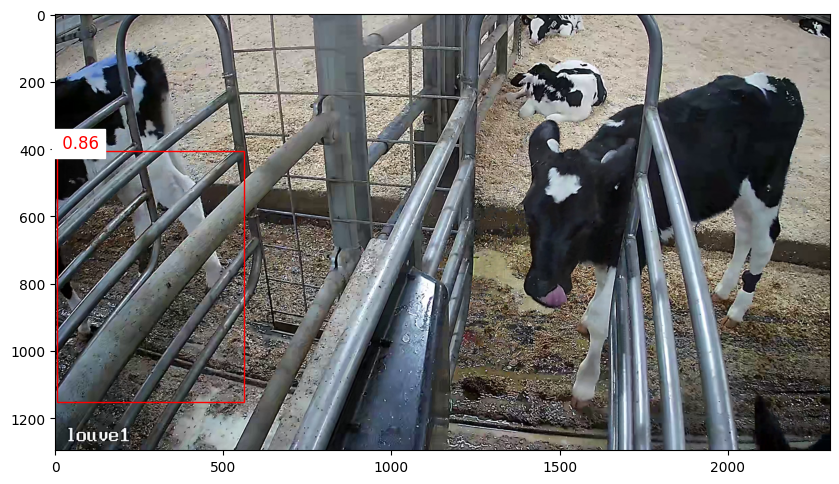

In [7]:
# img_path = ROOT_DIR + "/video_classification/temp_images/Pneumonie/image_7_11_6768_2_2022-02-22 21:04:36_Pneumonie.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Pneumonie/image_0_4_6375_10_2022-03-01 19:46:38_Pneumonie.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Healthy/image_1_15_6728_10_2022-02-19 20:56:23_Healthy.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Diarrhé/image_9_15_6393_10_2022-02-16 09:01:56_Diarrhé.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Diarrhé/image_6_7_6799_1_2022-02-26 18:32:00_Diarrhé.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Diarrhé/image_6_1_6778_2_2022-02-26 18:06:52_Diarrhé.png"
img_path = ROOT_DIR + "/video_classification/temp_images/Healthy/image_1058_1_6774_2_2022-02-17 13:11:39_Healthy.png"

# results = finetuned_model.predict(img_path, save=False, imgsz=640, conf=0.5, max_det=15, show=False)
results = finetuned_model.predict(img_path, save=False, conf=0.8, max_det=1, show=False, visualize=False)

result = results[0]
boxes = result.boxes  # Assuming the results contain 'boxes'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
ax = plt.gca()
print(boxes.shape[0] == 0)

# Plot the bounding boxes and labels
# for box, label, score in zip(boxes, labels, scores):
for box in zip(boxes):
    # print(box)
    x1, y1, width, height = box[0].xywh[0].cpu()
    score = box[0].conf[0].cpu()
    # width, height = x2 - x1, y2 - y1
    x1 = x1 - (width / 2)
    y1 = y1 - (height / 2)
    rect = plt.Rectangle((x1, y1), width, height, edgecolor='r', facecolor='none')
    # rect = plt.Rectangle((x1 - 160, y1 - 240), width, height, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x1, y1 - 10, f' {score:.2f}', color='red', fontsize=12, backgroundcolor='white')

# plt.axis('off')
plt.show()


image 1/1 /data/konrad/datasets/mixed_10/images/Diarrhé, Pneumonie/image_169_64_9_6780_2_2022-02-18 20:16:00_Diarrhé, Pneumonie.png: 384x640 (no detections), 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
True


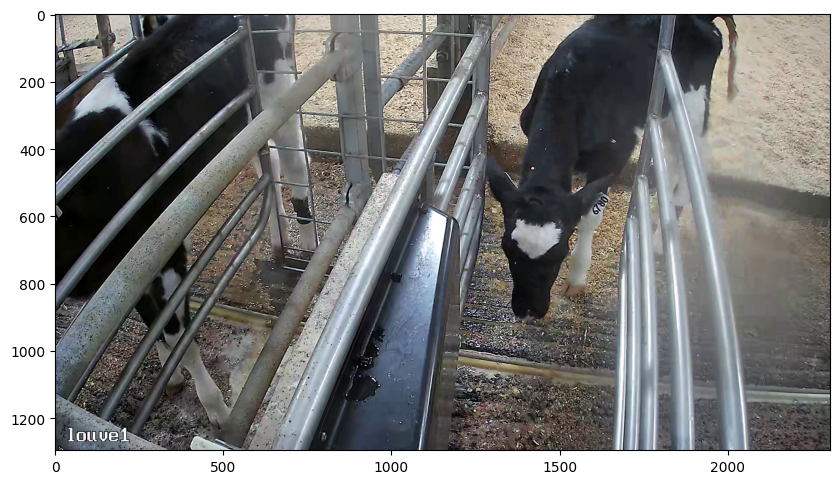

In [11]:
# img_path = ROOT_DIR + "/video_classification/temp_images/Pneumonie/image_7_11_6768_2_2022-02-22 21:04:36_Pneumonie.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Pneumonie/image_0_4_6375_10_2022-03-01 19:46:38_Pneumonie.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Healthy/image_1_15_6728_10_2022-02-19 20:56:23_Healthy.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Diarrhé/image_9_15_6393_10_2022-02-16 09:01:56_Diarrhé.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Diarrhé/image_6_7_6799_1_2022-02-26 18:32:00_Diarrhé.png"
# img_path = ROOT_DIR + "/video_classification/temp_images/Diarrhé/image_6_1_6778_2_2022-02-26 18:06:52_Diarrhé.png"
# img_path = ROOT_DIR + "/datasets/mixed_10/images/Diarrhé, Pneumonie/image_24_17_4_6370_10_2022-02-18 19:18:12_Diarrhé, Pneumonie.png"
# img_path = ROOT_DIR + "/datasets/mixed_10/images/Diarrhé, Pneumonie/image_49_17_9_6370_10_2022-02-18 19:18:12_Diarrhé, Pneumonie.png"
# img_path = ROOT_DIR + "/datasets/mixed_10/images/Diarrhé/image_56_24_5_6768_2_2022-02-18 09:45:40_Diarrhé.png"
img_path = ROOT_DIR + "/datasets/mixed_10/images/Diarrhé, Pneumonie/image_169_64_9_6780_2_2022-02-18 20:16:00_Diarrhé, Pneumonie.png"

# results = finetuned_model.predict(img_path, save=False, imgsz=640, conf=0.5, max_det=15, show=False)
results = finetuned_model.predict(img_path, save=False, conf=0.8, max_det=1, show=False, visualize=False)

result = results[0]
boxes = result.boxes  # Assuming the results contain 'boxes'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
ax = plt.gca()
print(boxes.shape[0] == 0)

# Plot the bounding boxes and labels
# for box, label, score in zip(boxes, labels, scores):
for box in zip(boxes):
    # print(box)
    x1, y1, width, height = box[0].xywh[0].cpu()
    score = box[0].conf[0].cpu()
    # width, height = x2 - x1, y2 - y1
    x1 = x1 - (width / 2)
    y1 = y1 - (height / 2)
    rect = plt.Rectangle((x1, y1), width, height, edgecolor='r', facecolor='none')
    # rect = plt.Rectangle((x1 - 160, y1 - 240), width, height, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.text(x1, y1 - 10, f' {score:.2f}', color='red', fontsize=12, backgroundcolor='white')

# plt.axis('off')
plt.show()

In [10]:
result.boxes[0].cls[0]

tensor(0., device='cuda:0')

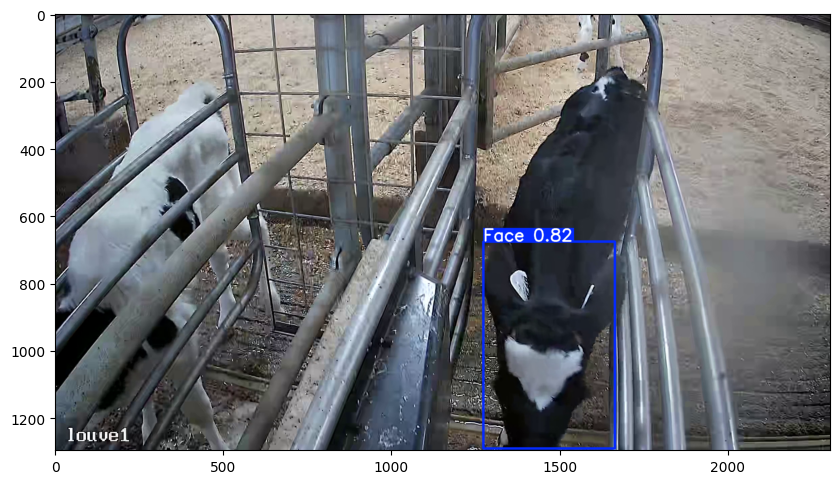

In [8]:
# Visualize the results
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    plt.figure(figsize=(10, 10))
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image
    plt.imshow(im_rgb)

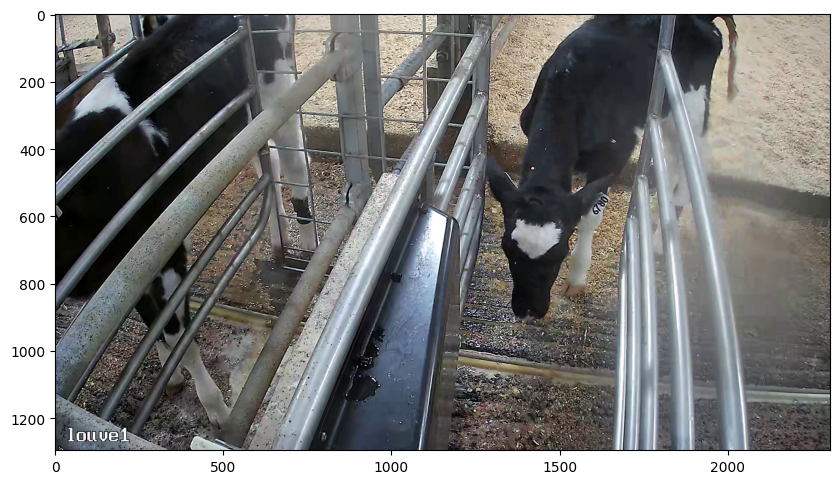

In [12]:
# Visualize the results
for i, r in enumerate(results):
    # Plot results image
    im_bgr = r.plot()  # BGR-order numpy array
    plt.figure(figsize=(10, 10))
    im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image
    plt.imshow(im_rgb)

In [ ]:
img_path = records[1][~records[1]["passed"]]["path"].tolist()[0]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

box = [records[1][~records[1]["passed"]]["box_x"].tolist()[0], records[1][~records[1]["passed"]]["box_y"].tolist()[0], records[1][~records[1]["passed"]]["box_width"].tolist()[0], records[1][~records[1]["passed"]]["box_height"].tolist()[0]]
x1, y1, w, h = box

x1 = x1 - (w / 2)
y1 = y1 - (h / 2)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
ax = plt.gca()

rect = plt.Rectangle((x1, y1), w, h, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.show()